I want to look at the similarities between the synthetic and acoustic samples.

Let's look at maybe trying to find acoustic and synthetic audio waveforms of the same instrument family at the same note.
Theoretically their fft's or spectrograms should be approximately the same, with maybe some differences.

Can I use a correlation function to examine their similarities? 

First let's load the data in

In [3]:
import pandas as pd

train_data = pd.read_json("nsynth-train/examples.json", orient='index')
test_data = pd.read_json("nsynth-test/examples.json", orient='index')
valid_data = pd.read_json("nsynth-valid/examples.json", orient='index')

#Set the indices from the file name to sequential integers for easier indexing later.
#File name is kept in note_str anyway
train_data['index'] = range(1, len(train_data) + 1)
train_data = train_data.reset_index()

test_data['index'] = range(1,len(test_data) + 1)
test_data = test_data.reset_index()

valid_data['index'] = range(1,len(valid_data)+1)
valid_data = valid_data.reset_index()

test_data.head()

,level_0,qualities,pitch,note,instrument_source_str,velocity,instrument_str,instrument,sample_rate,qualities_str,instrument_source,note_str,instrument_family,instrument_family_str,index
0,bass_synthetic_068-049-025,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",49,217499,synthetic,25,bass_synthetic_068,656,16000,[dark],2,bass_synthetic_068-049-025,0,bass,1
1,keyboard_electronic_001-021-127,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",21,299359,electronic,127,keyboard_electronic_001,40,16000,[],1,keyboard_electronic_001-021-127,4,keyboard,2
2,guitar_acoustic_010-066-100,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",66,72288,acoustic,100,guitar_acoustic_010,219,16000,[],0,guitar_acoustic_010-066-100,3,guitar,3
3,reed_acoustic_037-068-127,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",68,22259,acoustic,127,reed_acoustic_037,387,16000,[reverb],0,reed_acoustic_037-068-127,7,reed,4
4,flute_acoustic_002-077-100,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",77,72001,acoustic,100,flute_acoustic_002,86,16000,[reverb],0,flute_acoustic_002-077-100,2,flute,5


Some functions for working with the data

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def getTrainWav(label):
    file_location = "nsynth-train/audio/" + label + ".wav"
    audio_binary = tf.io.read_file(file_location)
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform

def getTestWav(label):
    file_location = "nsynth-test/audio/" + label + ".wav"
    audio_binary = tf.io.read_file(file_location)
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform

def getValidWav(label):
    file_location = "nsynth-valid/audio" + label + ".wav"
    audio_binary = tf.io.read_file(file_location)
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform

def getSpectrogram(waveform):
    #zero pad to 64k samples, since each audio clip is 4 seconds sampled at 16kHz
    input_len = 64000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
      [64000] - tf.shape(waveform),
      dtype=tf.float32)

    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

Separate acoustic and synthetic vocal data at same pitch.

In [5]:
vocal_acoustic = train_data.loc[(train_data['instrument_source_str'] == 'acoustic') & (train_data['instrument_family_str'] == 'vocal') & (train_data['pitch'] == 64) & (train_data['velocity'] == 75)]

vocal_acoustic.head()

,level_0,note,sample_rate,pitch,instrument_source,instrument_family_str,instrument_str,note_str,qualities_str,instrument_source_str,velocity,instrument_family,instrument,qualities,index
27759,vocal_acoustic_005-064-075,55069,16000,64,0,vocal,vocal_acoustic_005,vocal_acoustic_005-064-075,[reverb],acoustic,75,10,130,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",27760
30853,vocal_acoustic_012-064-075,59867,16000,64,0,vocal,vocal_acoustic_012,vocal_acoustic_012-064-075,"[long_release, reverb]",acoustic,75,10,281,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",30854
55972,vocal_acoustic_022-064-075,3930,16000,64,0,vocal,vocal_acoustic_022,vocal_acoustic_022-064-075,[reverb],acoustic,75,10,372,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",55973
67351,vocal_acoustic_016-064-075,28081,16000,64,0,vocal,vocal_acoustic_016,vocal_acoustic_016-064-075,"[long_release, reverb]",acoustic,75,10,318,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",67352
77069,vocal_acoustic_014-064-075,18002,16000,64,0,vocal,vocal_acoustic_014,vocal_acoustic_014-064-075,"[long_release, reverb]",acoustic,75,10,300,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0]",77070


In [6]:
vocal_synth = train_data.loc[(train_data['instrument_source_str'] == 'synthetic') & (train_data['instrument_family_str'] == 'vocal') & (train_data['pitch'] == 64) & (train_data['velocity'] == 75)]

vocal_synth.qualities.value_counts()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]    5
[0, 0, 1, 0, 1, 0, 0, 0, 0, 0]    4
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]    1
[1, 0, 1, 0, 1, 0, 0, 0, 0, 0]    1
[0, 0, 0, 0, 1, 0, 1, 0, 0, 1]    1
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]    1
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]    1
Name: qualities, dtype: int64

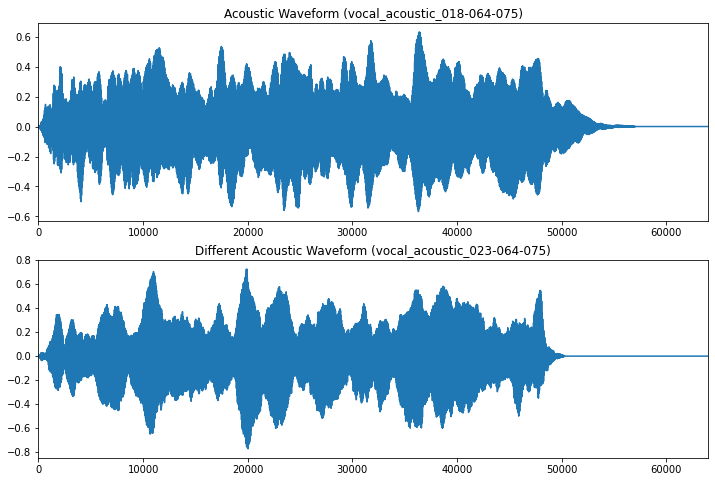

In [273]:
import matplotlib.pyplot as plt

acoustic_waveform = getTrainWav(vocal_acoustic.iloc[9].loc['note_str'])
# synthetic_waveform = getTrainWav(vocal_synth.iloc[8].loc['note_str'])
synthetic_waveform = getTrainWav(vocal_acoustic.iloc[8].loc['note_str'])

acoustic_waveform = acoustic_waveform - np.mean(acoustic_waveform)
synthetic_waveform = synthetic_waveform - np.mean(synthetic_waveform)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(acoustic_waveform.shape[0])
axes[0].plot(timescale, acoustic_waveform.numpy())
axes[0].set_title('Acoustic Waveform (' + vocal_acoustic.iloc[9].loc['note_str'] + ')')
axes[0].set_xlim([0, 64000])

axes[1].plot(timescale, synthetic_waveform.numpy())
axes[1].set_title('Different Acoustic Waveform (' + vocal_acoustic.iloc[8].loc['note_str'] + ')')
axes[1].set_xlim([0, 64000])

plt.show()

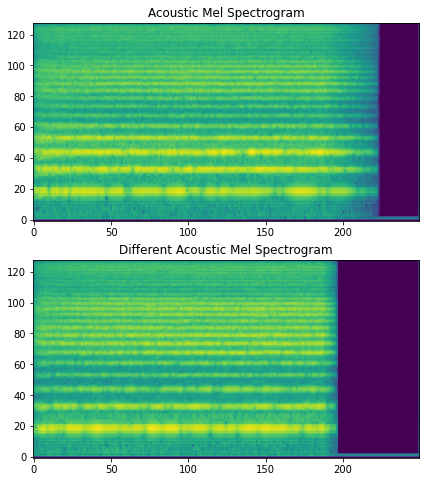

In [274]:
import tensorflow_io as tfio

def get_spectrogram(waveform):
    frame_length = 512
    frame_step = 256
    mel_spectrogram = tfio.audio.melscale(tfio.audio.spectrogram(input=tf.cast(waveform, tf.float32), nfft=frame_length, window=frame_length, stride=frame_step), rate=16000, mels=128, fmin=0, fmax=8000)
    return mel_spectrogram

# acoustic_spec = tfio.audio.dbscale(tf.cast(get_spectrogram(acoustic_waveform),dtype=tf.float32), top_db=80)
# synthetic_spec = tfio.audio.dbscale(tf.cast(get_spectrogram(synthetic_waveform),dtype=tf.float32), top_db=80)
acoustic_spec = tf.math.log(tf.cast(get_spectrogram(acoustic_waveform),dtype=tf.float32)+1e-6)
synthetic_spec = tf.math.log(tf.cast(get_spectrogram(synthetic_waveform),dtype=tf.float32)+1e-6)

fig, axes = plt.subplots(2, figsize=(12, 8))
# timescale = np.arange(vocal_acoustic_fft.shape[0])
axes[0].imshow(tf.transpose(acoustic_spec))
axes[0].set_title('Acoustic Mel Spectrogram')
axes[0].invert_yaxis()
# axes[0].set_xlim([0, 32000])

axes[1].imshow(tf.transpose(synthetic_spec))
axes[1].set_title('Different Acoustic Mel Spectrogram')
axes[1].invert_yaxis()
# axes[1].set_xlim([0, 32000])

plt.show()

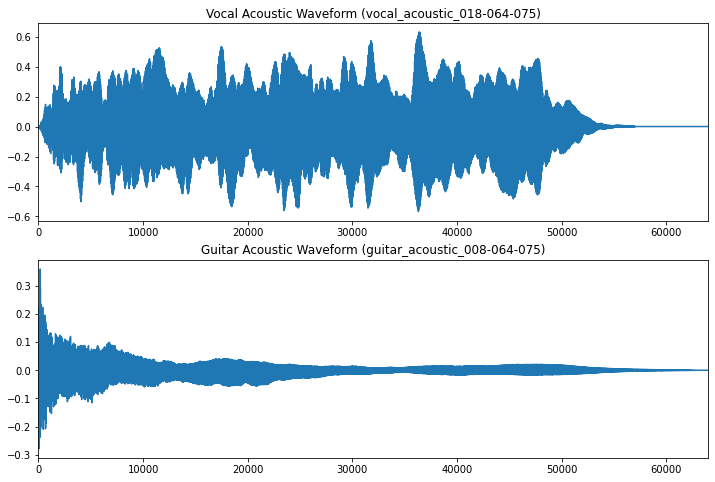

In [275]:
guitar_acoustic = train_data.loc[(train_data['instrument_source_str'] == 'acoustic') & (train_data['instrument_family_str'] == 'guitar') & (train_data['pitch'] == 64) & (train_data['velocity'] == 75)]
guitar_waveform = getTrainWav(guitar_acoustic.iloc[2].loc['note_str'])

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(acoustic_waveform.shape[0])
axes[0].plot(timescale, acoustic_waveform.numpy())
axes[0].set_title('Vocal Acoustic Waveform (' + vocal_acoustic.iloc[9].loc['note_str'] + ')')
axes[0].set_xlim([0, 64000])

axes[1].plot(timescale, guitar_waveform.numpy())
axes[1].set_title('Guitar Acoustic Waveform (' + guitar_acoustic.iloc[1].loc['note_str'] + ')')
axes[1].set_xlim([0, 64000])

plt.show()

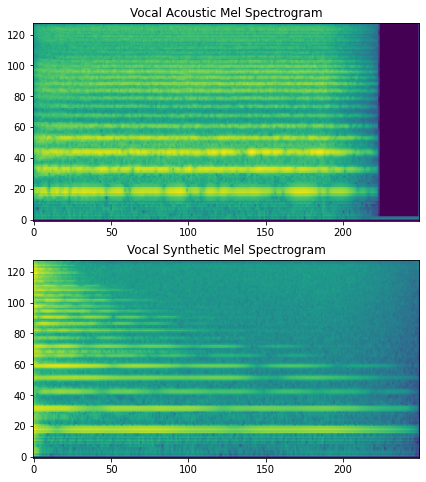

In [276]:
# guitar_spec = tfio.audio.dbscale(tf.cast(get_spectrogram(guitar_waveform),dtype=tf.float32), top_db=80)
guitar_spec = tf.math.log(tf.cast(get_spectrogram(guitar_waveform),dtype=tf.float32)+1e-6)

fig, axes = plt.subplots(2, figsize=(12, 8))
# timescale = np.arange(vocal_acoustic_fft.shape[0])
axes[0].imshow(tf.transpose(acoustic_spec))
axes[0].set_title('Vocal Acoustic Mel Spectrogram')
axes[0].invert_yaxis()
# axes[0].set_xlim([0, 32000])

axes[1].imshow(tf.transpose(guitar_spec))
axes[1].set_title('Vocal Synthetic Mel Spectrogram')
axes[1].invert_yaxis()
# axes[1].set_xlim([0, 32000])

plt.show()

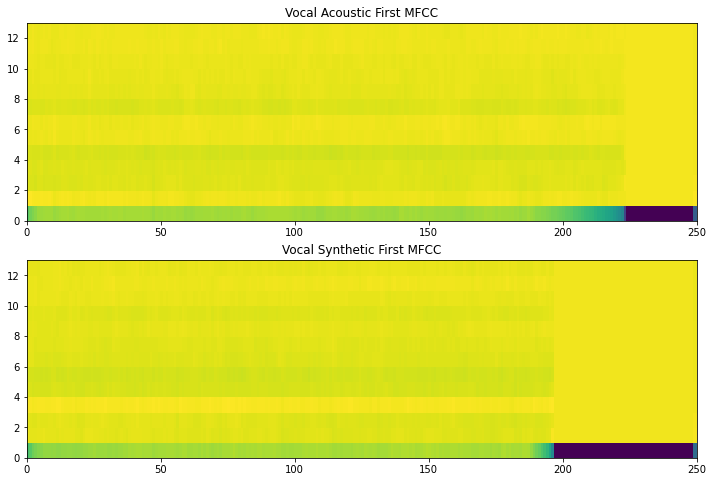

In [262]:
acoustic_mfccs = tf.signal.mfccs_from_log_mel_spectrograms(acoustic_spec)[..., :13]
synthetic_mfccs = tf.signal.mfccs_from_log_mel_spectrograms(synthetic_spec)[..., :13]
guitar_mfccs = tf.signal.mfccs_from_log_mel_spectrograms(guitar_spec)[..., :13]

# acoustic_mfcc1 = acoustic_mfccs[0] / np.max(acoustic_mfccs[0])
# synthetic_mfcc1 = synthetic_mfccs[0] / np.max(synthetic_mfccs[0])
# guitar_mfcc1 = guitar_mfccs[0] / np.max(guitar_mfccs[0])

# acoustic_mfcc1 = np.mean(acoustic_mfccs,0) 
# synthetic_mfcc1 = np.mean(synthetic_mfccs,0)
# guitar_mfcc1 = np.mean(guitar_mfccs,0) 

# acoustic_mfcc1 = acoustic_mfcc1 / np.max(acoustic_mfcc1)
# synthetic_mfcc1 = synthetic_mfcc1 / np.max(synthetic_mfcc1)
# guitar_mfcc1 = guitar_mfcc1 / np.max(guitar_mfcc1)

fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].pcolor(tf.transpose(acoustic_mfccs))
ax[0].set_title('Vocal Acoustic First MFCC')
ax[1].pcolor(tf.transpose(synthetic_mfccs))
ax[1].set_title('Vocal Synthetic First MFCC')
plt.show()

In [188]:
acoustic_spec

<tf.Tensor: shape=(250, 128), dtype=float32, numpy=
array([[-13.815511 ,  -3.9352093,  -5.111237 , ...,  -4.6008434,
         -5.4045243,  -7.0211644],
       [-13.815511 ,  -3.6406481,  -4.816705 , ...,  -3.403651 ,
         -4.8894124,  -6.0538344],
       [-13.815511 ,  -2.4083922,  -3.5845098, ...,  -3.1060686,
         -4.0622993,  -6.3497915],
       ...,
       [-13.815511 ,  -6.0846443,  -7.2598033, ..., -13.815388 ,
        -13.815416 , -13.814507 ],
       [-13.815511 ,  -6.0846443,  -7.2598033, ..., -13.815388 ,
        -13.815416 , -13.814507 ],
       [-13.815511 ,  -6.2988677,  -7.4737916, ...,  -9.7046175,
         -9.689885 ,  -9.675074 ]], dtype=float32)>

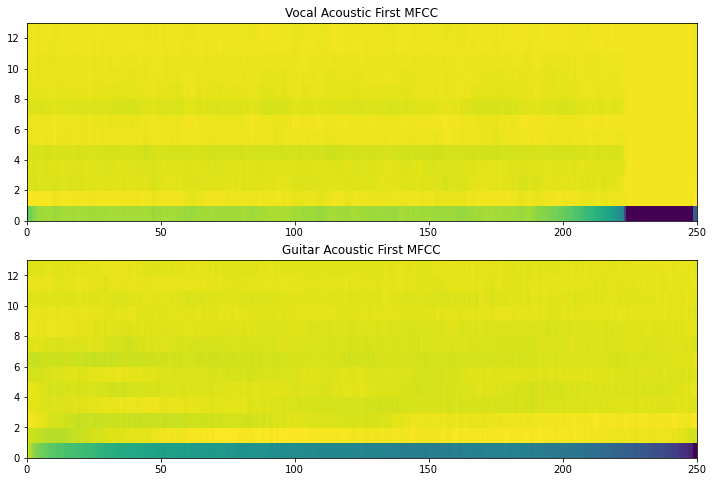

In [231]:
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0].pcolor(tf.transpose(acoustic_mfccs))
ax[0].set_title('Vocal Acoustic First MFCC')
ax[1].pcolor(tf.transpose(guitar_mfccs))
ax[1].set_title('Guitar Acoustic First MFCC')
plt.show()

25451.107


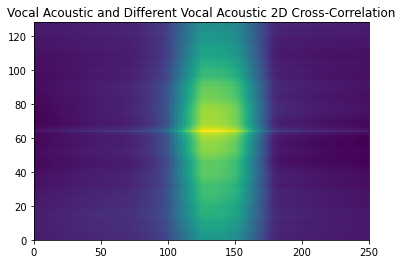

In [278]:
acoustic_spec = (acoustic_spec - np.mean(acoustic_spec))/(np.std(acoustic_spec))
synthetic_spec = (synthetic_spec - np.mean(synthetic_spec))/(np.std(synthetic_spec))

vocal_cor = correlate(acoustic_spec, synthetic_spec, 'same')

print(np.max(vocal_cor))

fig, ax = plt.subplots()
ax.pcolor(tf.transpose(vocal_cor))
ax.set_title('Vocal Acoustic and Different Vocal Acoustic 2D Cross-Correlation')
plt.show()

17927.973


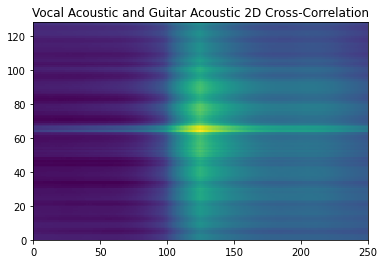

In [272]:
guitar_spec = (guitar_spec - np.mean(guitar_spec))/(np.std(guitar_spec))

guitar_cor = correlate(acoustic_spec, guitar_spec, 'same')
print(np.max(guitar_cor))

fig, ax = plt.subplots()
ax.pcolor(tf.transpose(guitar_cor))
ax.set_title('Vocal Acoustic and Guitar Acoustic 2D Cross-Correlation')
plt.show()